In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [18]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

CHANNELS = 3
EPOCHS = 30

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [11]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 2, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 2, 0, 1, 0, 0, 0, 1])>

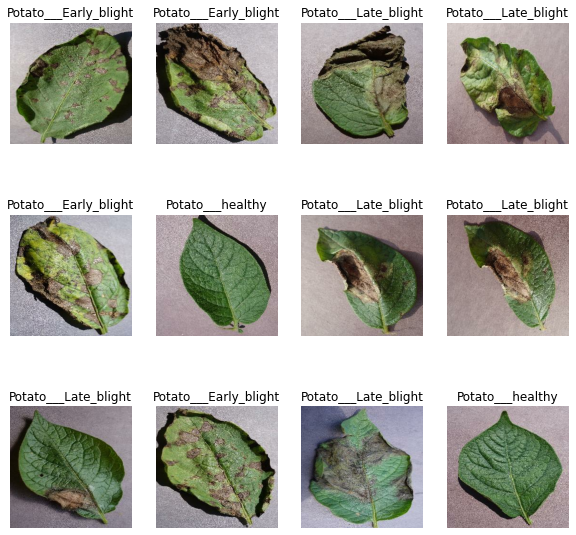

In [17]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

#### Split Dataset

In [19]:
"""
80% ==> training purpose,
20% ==> 10% for validation, 10% for test
"""

'\n80% ==> training purpose,\n20% ==> 10% for validation, 10% for test\n'

In [21]:
train_size = 0.8
len(dataset)*train_size


54.400000000000006

In [22]:
train_ds = dataset.take(54)
len(train_ds)

54

In [23]:
test_ds = dataset.skip(54) #remaining 20%
len(test_ds)

14

In [24]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [25]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [26]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [27]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [28]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [29]:
len(train_ds)

54

In [30]:
len(val_ds)

6

In [31]:
len(test_ds)

8

### Input Preprocessing

In [32]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Building

In [36]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [38]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 [==============================] - 150s 2s/step - loss: 0.8919 - accuracy: 0.5284 - val_loss: 0.8567 - val_accuracy: 0.5417
Epoch 2/30
54/54 [==============================] - 114s 2s/step - loss: 0.6558 - accuracy: 0.6881 - val_loss: 0.5333 - val_accuracy: 0.7344
Epoch 3/30
54/54 [==============================] - 114s 2s/step - loss: 0.4271 - accuracy: 0.8166 - val_loss: 0.3663 - val_accuracy: 0.8073
Epoch 4/30
54/54 [==============================] - 113s 2s/step - loss: 0.2820 - accuracy: 0.8819 - val_loss: 0.2569 - val_accuracy: 0.9010
Epoch 5/30
54/54 [==============================] - 112s 2s/step - loss: 0.2379 - accuracy: 0.8993 - val_loss: 0.1150 - val_accuracy: 0.9635
Epoch 6/30
54/54 [==============================] - 112s 2s/step - loss: 0.2317 - accuracy: 0.9062 - val_loss: 0.1586 - val_accuracy: 0.9323
Epoch 7/30
54/54 [==============================] - 112s 2s/step - loss: 0.1702 - accuracy: 0.9329 - val_loss: 0.1021 - val_accuracy: 0.9531
Epoch 8/30
54

In [40]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 9s 603ms/step - loss: 0.0921 - accuracy: 0.9727


In [41]:
scores

[0.09212221950292587, 0.97265625]

In [42]:
history

In [43]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
history.history['accuracy']

[0.5283564925193787,
 0.6880787014961243,
 0.8165509104728699,
 0.8819444179534912,
 0.8993055820465088,
 0.90625,
 0.9328703880310059,
 0.953125,
 0.9490740895271301,
 0.9594907164573669,
 0.9571759104728699,
 0.9652777910232544,
 0.9618055820465088,
 0.9565972089767456,
 0.9670138955116272,
 0.9733796119689941,
 0.9774305820465088,
 0.9820601940155029,
 0.9774305820465088,
 0.9826388955116272,
 0.9791666865348816,
 0.9861111044883728,
 0.9809027910232544,
 0.9826388955116272,
 0.9901620149612427,
 0.984375,
 0.9780092835426331,
 0.9820601940155029,
 0.9913194179534912,
 0.9872685074806213]

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

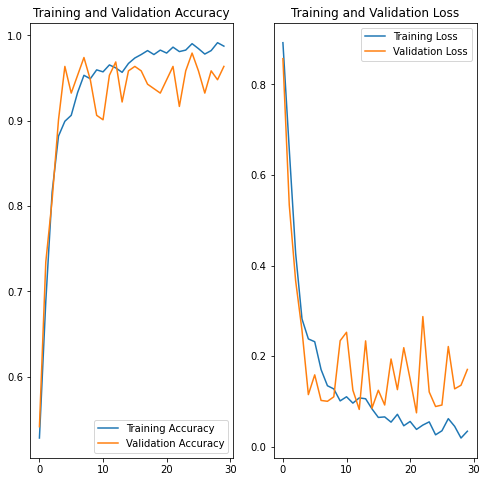

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

First Image to Predict
first image's actual label:  Potato___Early_blight
1/1 [==============================] - 1s 660ms/step
Predicted Label:  Potato___Early_blight


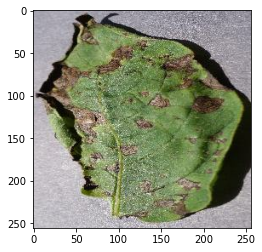

In [68]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("First Image to Predict")
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [73]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


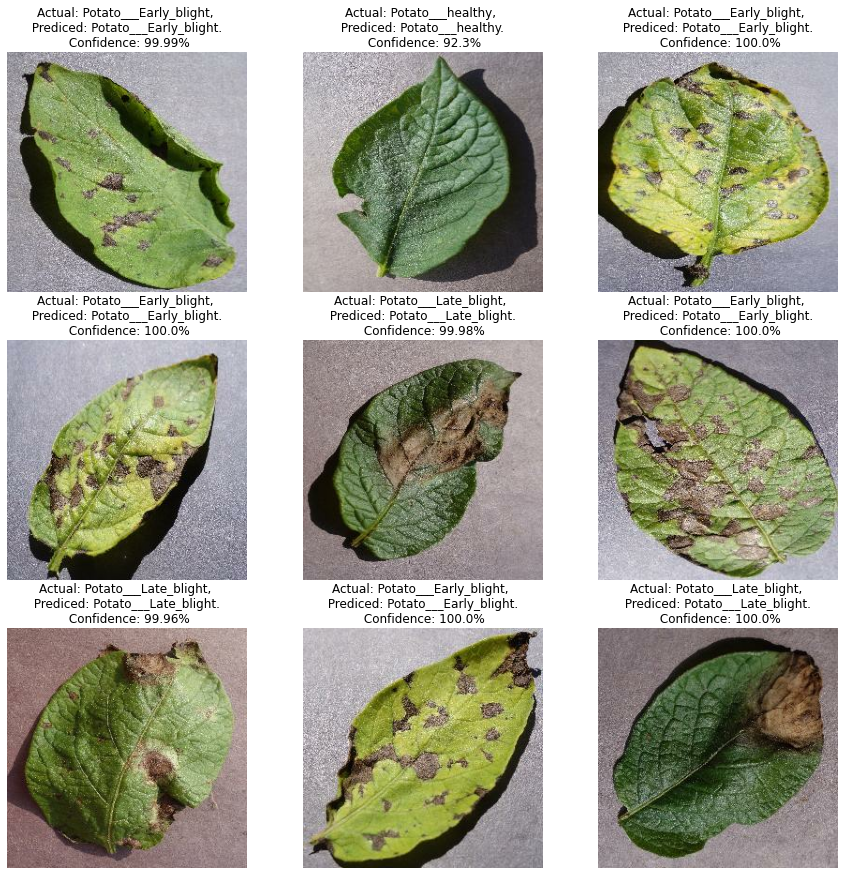

In [79]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Prediced: {predicted_class}. \n Confidence: {confidence}%")
        
        plt.axis('off')
        

### Saving Model

In [82]:
# model_version = 1
# model.save(f"../models/{model_version}")

#or

import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
